##Laboratory work 5

In this laboratory work it was necessary to carry out numerical simulation of a parabolic type equation.
In the center of a square periodically closed region there is a smooth dome-shaped potential barrier. Model the scattering of a plane wave packet at a given potential.

The potential is given by the formula:
\begin{equation}
  U(x, y) = U_0 a(\sqrt{x^2 + y^2}; ɛ)
\end{equation}
where:
\begin{equation}
  a(r;ɛ) = η(ɛ - |r|) \cos^3({\frac{πr}{2ɛ}})
\end{equation}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as linalg

In [2]:
# grid creating
h0 = 0.01
l_x = 5
l_y = 5
nx = int(np.round(l_x / h0))
ny = int(np.round(l_y / h0))

hx = l_x / nx
hy = l_y / ny

x = np.linspace(- l_x / 2 + 0.5 * hx, l_x / 2 - 0.5 * hx, nx)
y = np.linspace(- l_y / 2 + 0.5 * hy, l_y / 2 - 0.5 * hy, ny)
X, Y = np.meshgrid(x, y, indexing = 'ij')

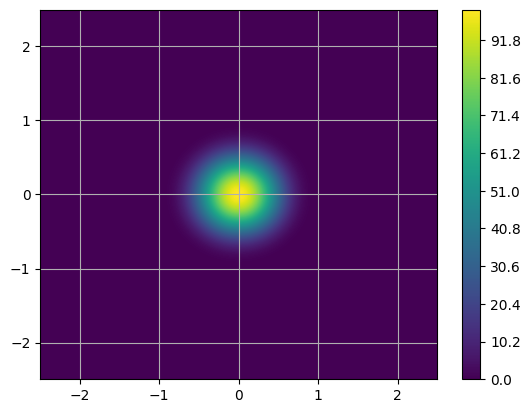

In [3]:
# potential
def U(X, Y, eps, U_0):
  return U_0 * np.heaviside(- X**2 - Y**2 + eps**2, 0) * np.cos(np.pi * np.sqrt(X**2 + Y**2) / (2 * eps))**3

plt.contourf(X, Y, U(X, Y, 1, 100), levels=500, cmap='viridis')
plt.colorbar()
plt.grid()
plt.show()

In [4]:
def H(nx, ny, U, hh = 1, m = 1):

  # cells indexing
  k = np.arange(nx * ny, dtype=int).reshape((nx, ny))

  # pair of indices
  I, J = np.meshgrid(np.arange(nx), np.arange(ny))
  I, J = I.flatten(), J.flatten()

  iC = k[I, J].flatten()

  iB = k[I, (J - 1) % ny].flatten()
  iT = k[I, (J + 1) % ny].flatten()

  iL = k[(I - 1) % nx, J].flatten()
  iR = k[(I + 1) % nx, J].flatten()
  U = U.flatten()

  # matrix filling
  R1, C1, V1 = iC, iC, np.full(iC.size, (hh**2 / (2*m)) * (+2.0 / hy**2 + 2.0 / hx**2) + U)
  R2, C2, V2 = iC, iB, np.full(iC.size, (hh**2 / (2*m)) * (-1.0 / hy**2))
  R3, C3, V3 = iC, iT, np.full(iC.size, (hh**2 / (2*m)) * (-1.0 / hy**2))
  R4, C4, V4 = iC, iL, np.full(iC.size, (hh**2 / (2*m)) * (-1.0 / hx**2))
  R5, C5, V5 = iC, iR, np.full(iC.size, (hh**2 / (2*m)) * (-1.0 / hx**2))

  row = np.concatenate((R1, R2, R3, R4, R5))
  col = np.concatenate((C1, C2, C3, C4, C5))
  val = np.concatenate((V1, V2, V3, V4, V5))

  L = sp.csr_matrix((val, (row, col)), shape=(nx * ny, nx * ny))
  return L

/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1578: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1579: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


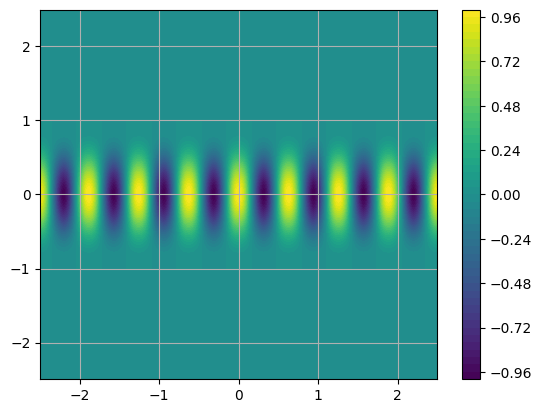

In [5]:
# wave_packet

def a(r, eps):
  return np.heaviside(- abs(r) + eps, 0) * np.cos((np.pi * r) / (2 * eps))**3

def wave_packet(x, y, x_0, y_0, kx, ky, n1, n2, eps):
    r = (x - x_0) * n1 + (y - y_0) * n2
    return a(r, eps) * np.exp(1j * (kx * x + ky * y))

x_0, y_0 = 0, 0
n1, n2 = 0, 1
kx, ky = 10, 0
eps = 1

psi_0 = wave_packet(X, Y, x_0, y_0, kx, ky, n1, n2, eps)
plt.contourf(X, Y, psi_0, levels=50, cmap='viridis')
plt.colorbar()
plt.grid()
plt.show()

In [6]:
tau = 0.01
v = 0.5

Hp = H(nx, ny, U(X, Y, 1, 100), hh = 1, m = 1)


A = sp.eye(nx * ny, format='csr') + 1j * tau * v * Hp
B = sp.eye(nx * ny, format='csr') - 1j * tau * (1 - v) * Hp

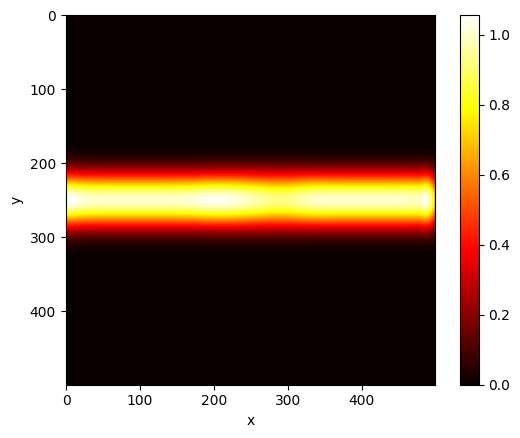

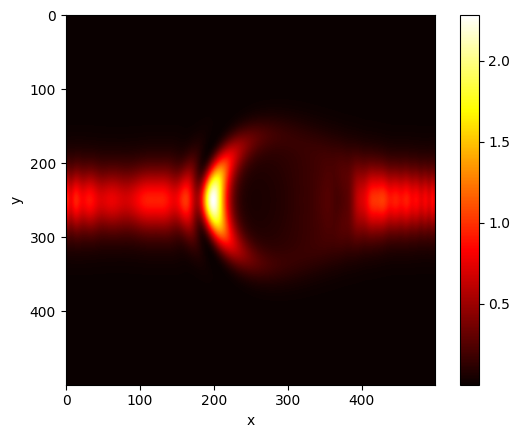

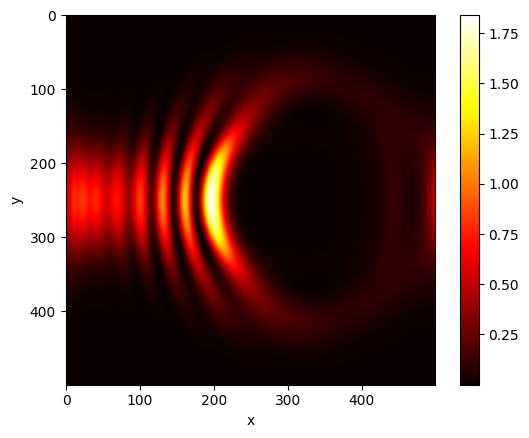

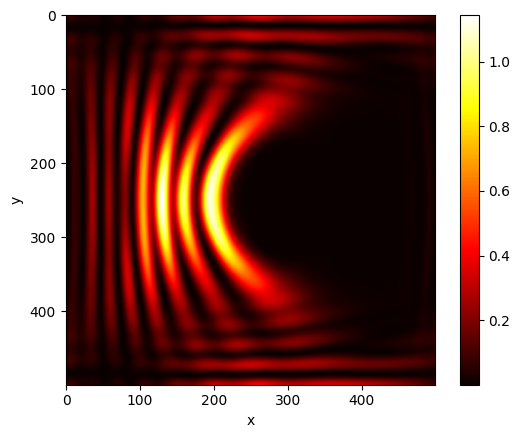

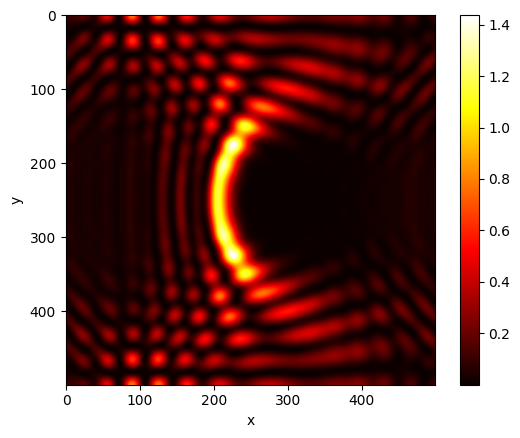

In [7]:
t_end = 0.5
psi = psi_0.flatten()
drawing_pause = 10

for i in range(int(t_end / tau)):
    psi = linalg.spsolve(A, B @ psi)
    if i % drawing_pause == 0:
        plt.imshow(np.abs(psi.reshape((nx, ny)).T)**2, cmap='hot')
        plt.colorbar()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
